In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [6]:
ts_confirmed = pd.read_csv("DATA/time_series_covid_19_confirmed.csv")
ts_confirmed_new = pd.read_csv("Data/time_series/time_series_19-covid-Confirmed.csv")
f_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(axis=0)[4:-1]
f_confirmed.index = pd.to_datetime(f_confirmed.index)


In [38]:
train = f_confirmed.where((f_confirmed<1000) & (f_confirmed>0)).dropna()
test = f_confirmed['2020-03-08':]

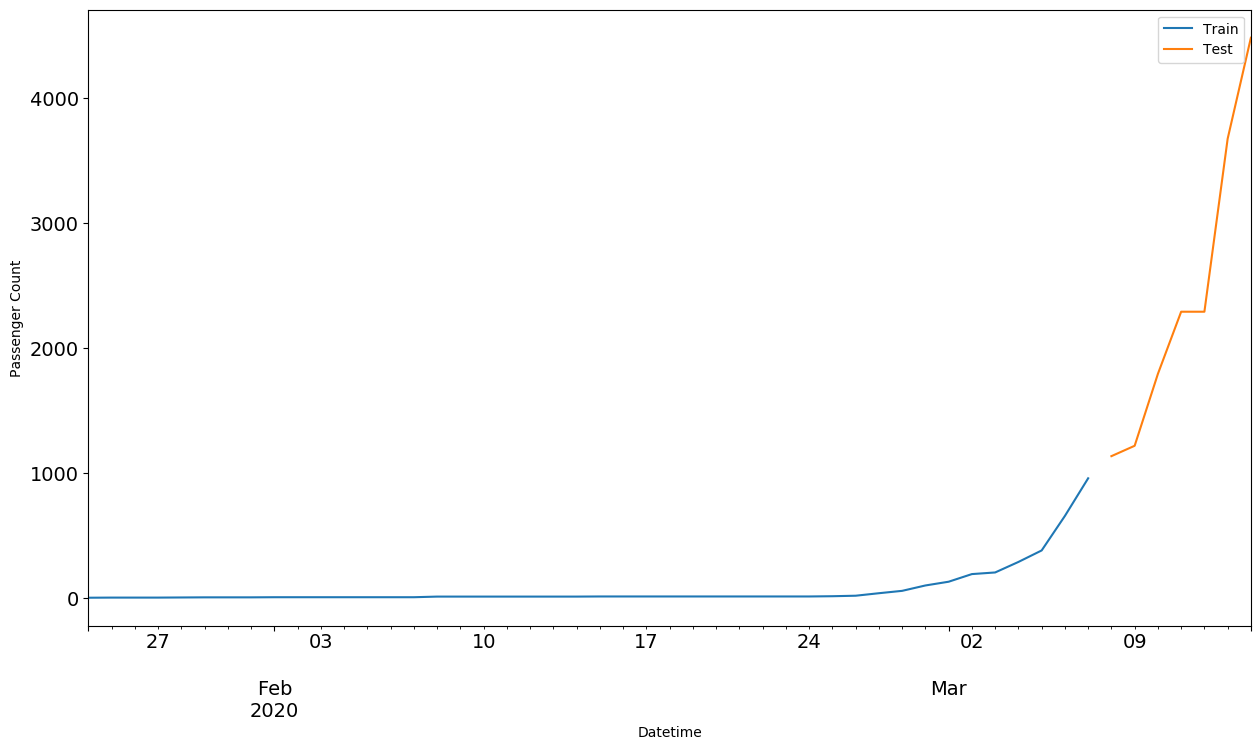

In [39]:
train.plot(figsize = (15,8), fontsize = 14, label = 'Train')
test.plot(figsize = (15,8), fontsize =14, label = 'Test')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')

## Holt's linear trend model

<Figure size 1600x800 with 0 Axes>

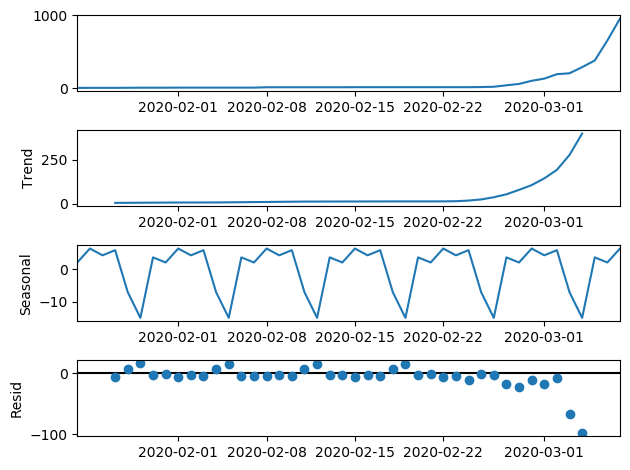

In [40]:
plt.style.use('default')
plt.figure(figsize = (16,8))
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

## ARIMA model

In [41]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

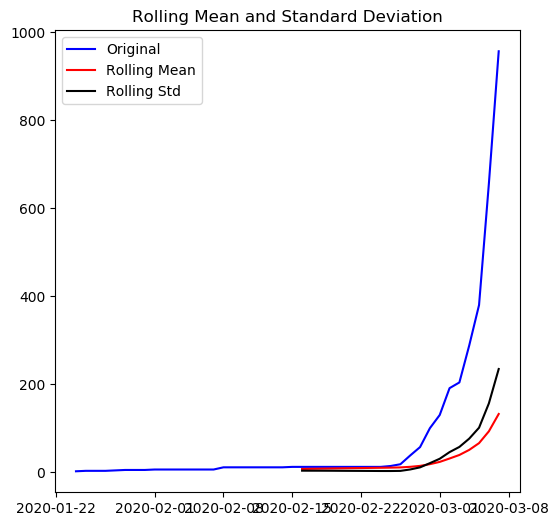

Results of Dickey Fuller test: 
Test Statistics                 1.458199
p-value                         0.997363
# Lag Used                      7.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [42]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(6,6)
test_stationary(train)

## Model

In [50]:
Train_log = train.apply(lambda x :np.log(x))
Test_log = train.apply(lambda x :np.log(x))

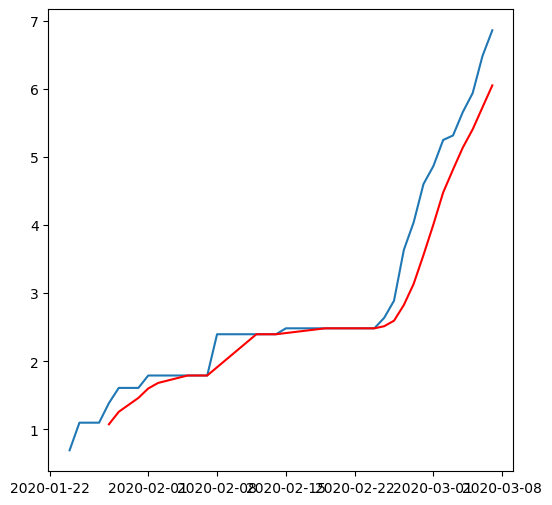

In [59]:
moving_avg = Train_log.rolling(5).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')

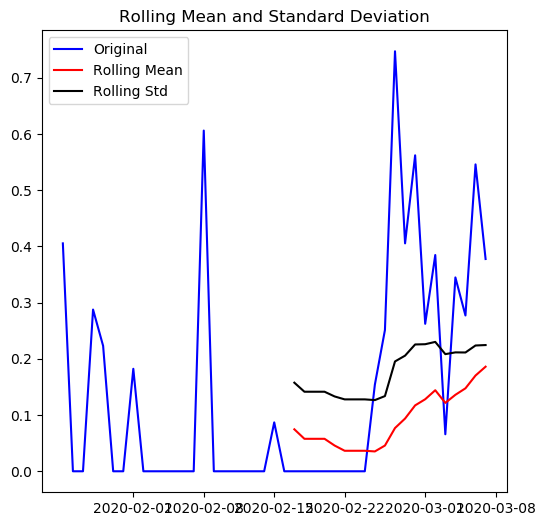

Results of Dickey Fuller test: 
Test Statistics                -2.101999
p-value                         0.243712
# Lag Used                      1.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [60]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


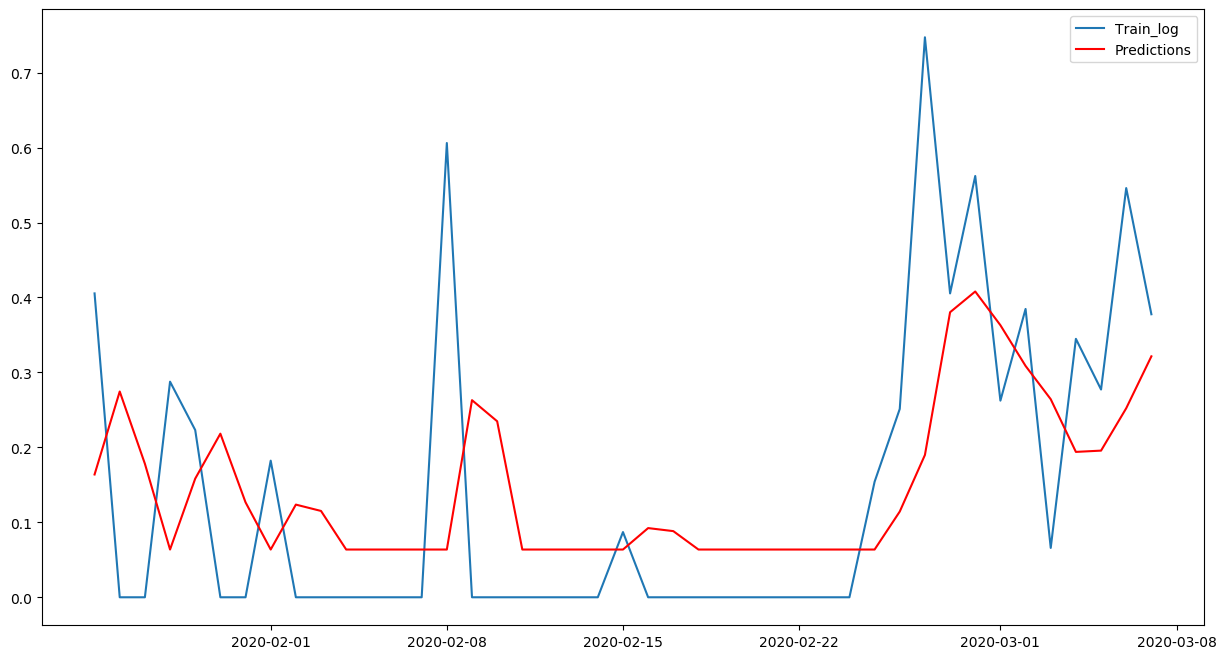

In [88]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize = (15,8))

model = ARIMA(Train_log, order = (2,1,0))  

results_AR = model.fit(disp=-1)

plt.plot(train_log_diff.dropna(), label = "Train_log")
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')

## SARIMAX Model

In [70]:
import statsmodels.api as sm

In [84]:
train

2020-01-24      2
2020-01-25      3
2020-01-26      3
2020-01-27      3
2020-01-28      4
2020-01-29      5
2020-01-30      5
2020-01-31      5
2020-02-01      6
2020-02-02      6
2020-02-03      6
2020-02-04      6
2020-02-05      6
2020-02-06      6
2020-02-07      6
2020-02-08     11
2020-02-09     11
2020-02-10     11
2020-02-11     11
2020-02-12     11
2020-02-13     11
2020-02-14     11
2020-02-15     12
2020-02-16     12
2020-02-17     12
2020-02-18     12
2020-02-19     12
2020-02-20     12
2020-02-21     12
2020-02-22     12
2020-02-23     12
2020-02-24     12
2020-02-25     14
2020-02-26     18
2020-02-27     38
2020-02-28     57
2020-02-29    100
2020-03-01    130
2020-03-02    191
2020-03-03    204
2020-03-04    288
2020-03-05    380
2020-03-06    656
2020-03-07    957
dtype: object

In [86]:
y_hat_avg = test.copy()

fit1 = sm.tsa.statespace.SARIMAX(train, order = (2,1,4), seasonal_order =(0,1,1,7)).fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [77]:
y_hat_avg['SARIMA'] = fit1.predict(start=test.index[0], end=test.index[-1], dynamic=True)

Text(0.5, 1.0, 'SARIMAX Model')

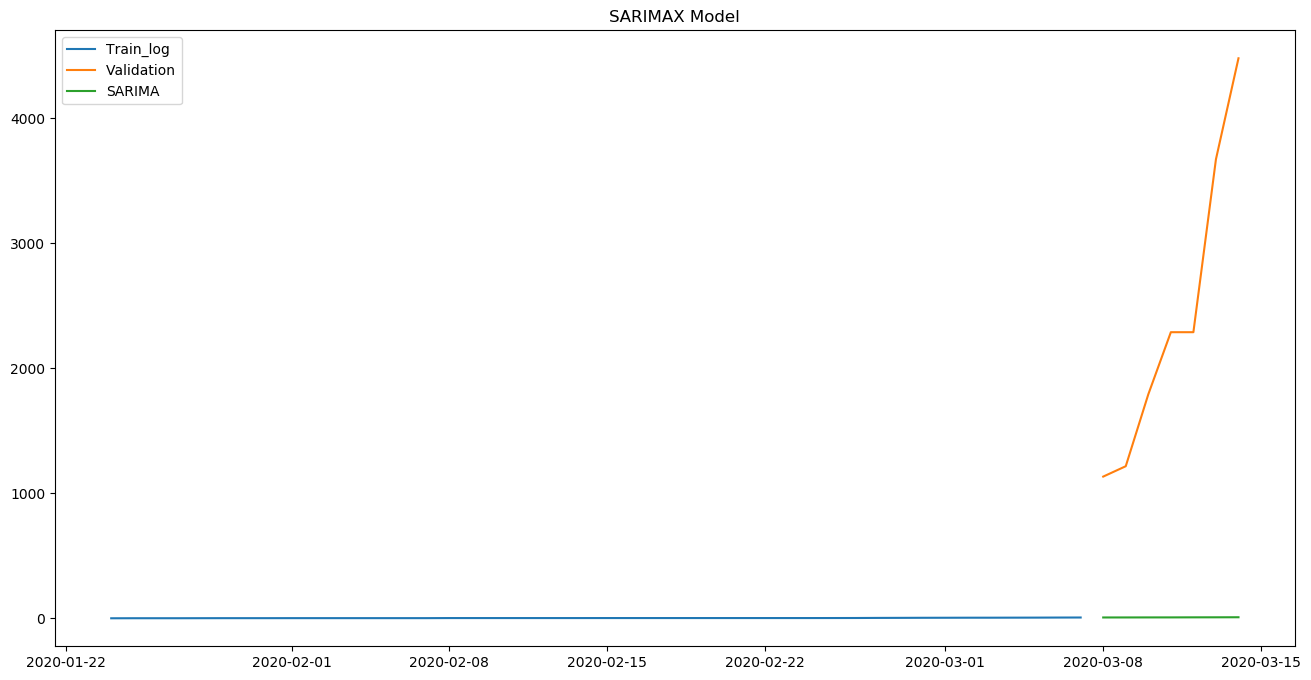

In [81]:
plt.figure(figsize=(16,8))
plt.plot(Train_log, label="Train_log")
plt.plot(test, label = "Validation")
plt.plot(y_hat_avg['SARIMA'], label ="SARIMA")
plt.legend(loc = "best")
plt.title("SARIMAX Model")